# The spatial distribution of grains

In [105]:
%run -i namespace.py

## Introduction

Our callborators made samples by melting and recrystallizing the powder rod. We would like to know how the single crystal grains distribute inside the recrystalized area.

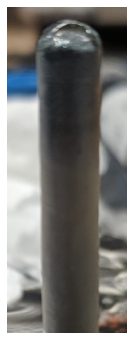

In [2]:
plt.figure(figsize=(8, 6))
plt.imshow(plt.imread("data/rod_picture.png"))
plt.axis("off")
plt.show()

We used x-ray to scan the area in a two dimensional grid and for each point on the grid, we measured the diffraction image at that point and the motor positions so that we obtained a mapping from postions to image.

At time $t$, $x(t),\ y(t) \rightarrow image(t)$

For each image, we subtract the background image.

$image \rightarrow processed\ image = image - background\ image$

For each processed image we found a region where there is a Bragg peak and extracted the peak intensity from each image using a peak tracking algorithm.

$processed\ image,\ peak\ \alpha \rightarrow intensity$

We tracked down this peak across a series of images. We finally got a mapping from positions on the sample to the intensity of a Bragg peak.

$\alpha,\ x,\ y \rightarrow intensity$

This mapping $intensity_\alpha(x, y)$ tells the information of the distribution of the grain whose Bragg peak is peak $\alpha$.

## Try with one of the grid scan data

We will get a map of peak intensity as a function of positions for one data set as an example.

### load the data

In [3]:
run = DB[UID["uid"].loc[1]]
metadata = run.metadata['start'].to_dict()
run

BlueskyRun
  uid='5959b25f-fcfc-4ec2-9187-7d8bce19711d'
  exit_status='success'
  2021-03-20 01:07:16.105 -- 2021-03-20 05:16:27.662
  Streams:
    * primary


In [4]:
data = run.primary.to_dask()
data = data.assign_attrs(metadata)
data = data.set_coords(["mXBase", "mXBase_user_setpoint", "mYBase", "mYBase_user_setpoint"])
data["index"] = (["time"], list(range(data.time.shape[0])))
data = data.set_index({"time": "index"})
data

<xarray.Dataset>
Dimensions:               (dim_0: 1, dim_1: 3888, dim_2: 3072, time: 4525)
Coordinates:
  * time                  (time) int64 0 1 2 3 4 5 ... 4520 4521 4522 4523 4524
    mXBase                (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mXBase_user_setpoint  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase                (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase_user_setpoint  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image          (time, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
Attributes: (12/22)
    time:                 1616216836.1055255
    uid:                  5959b25f-fcfc-4ec2-9187-7d8bce19711d
    versions:             {'ophyd': '1.3.3', 'bluesky': '1.6.7'}
    scan_id:              61
    proposal_id:          307690
    plan_type:            generator
    ...                   ...
    plan_pattern:         outer_product
    plan_pattern_args:    {'args': ["EpicsMotor(prefix='XF:28IDD-ES:2{Stg:Sta...
    plan_pattern_module:  bluesky.plan_patterns
    task:                 a coarse grid rocking curve
    sample:               PARAMID-2
    beam:                 slit

### Visualize the distribution of the sum of intensities

We visualize the distribution of the sum of intensities to find out where the rod is on the grid and where we can find background images.

Here, we define the beam position in the sample frame: $x_{beam} =  -x_{motor},\ y_{beam} = -y_{motor}$.

In [5]:
total_intensity = reshape(data, "dexela_stats1_total")

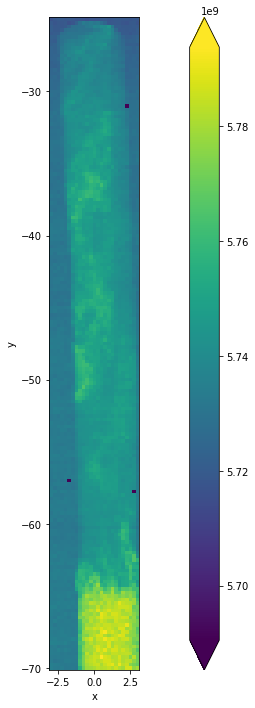

In [6]:
_ = my_color_map(total_intensity, size=12)

### Pick the background

Pick one image of pure air scattering as the background and use it to subtract other images.

In [7]:
# here the position is the motor position
background_dexela_image = data["dexela_image"][4524].compute()
background_dexela_image

<xarray.DataArray 'dexela_image' (dim_0: 1, dim_1: 3888, dim_2: 3072)>
array([[[518, 439, 527, ..., 627, 611, 629],
        [499, 483, 507, ..., 508, 576, 563],
        [417, 497, 446, ..., 532, 498, 543],
        ...,
        [549, 566, 528, ..., 479, 484, 445],
        [580, 579, 564, ..., 586, 446, 541],
        [607, 595, 634, ..., 511, 547, 500]]], dtype=uint16)
Coordinates:
    time                  int64 4524
    mXBase                float64 3.0
    mXBase_user_setpoint  float64 3.0
    mYBase                float64 70.0
    mYBase_user_setpoint  float64 70.0
Dimensions without coordinates: dim_0, dim_1, dim_2
Attributes:
    object:   dexela

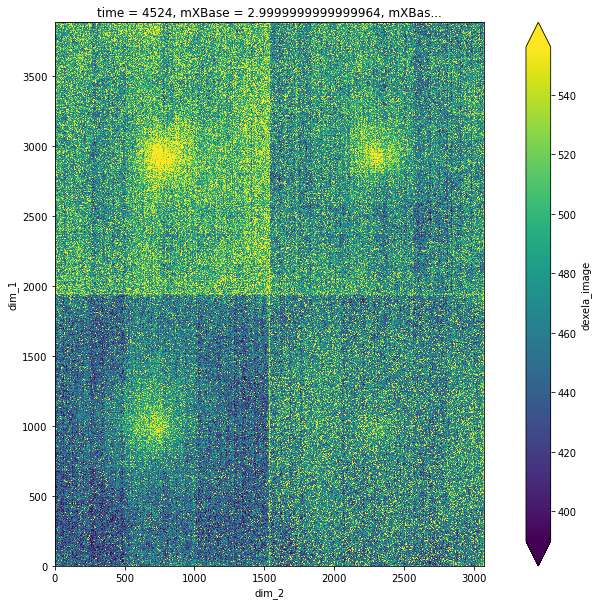

In [8]:
_ = my_color_map(background_dexela_image, size=10)

### Try the background subtraction

We select a data with Bragg peak and test the background subtraction.

In [9]:
test_dexela_image = data["dexela_image"][2514].compute()
test_dexela_image

<xarray.DataArray 'dexela_image' (dim_0: 1, dim_1: 3888, dim_2: 3072)>
array([[[515, 442, 517, ..., 644, 609, 631],
        [505, 480, 491, ..., 495, 593, 581],
        [421, 501, 461, ..., 518, 501, 546],
        ...,
        [565, 558, 538, ..., 483, 497, 442],
        [570, 586, 577, ..., 590, 447, 546],
        [633, 621, 632, ..., 520, 552, 489]]], dtype=uint16)
Coordinates:
    time                  int64 2514
    mXBase                float64 0.5
    mXBase_user_setpoint  float64 0.5
    mYBase                float64 50.0
    mYBase_user_setpoint  float64 50.0
Dimensions without coordinates: dim_0, dim_1, dim_2
Attributes:
    object:   dexela

This is the data we selected.

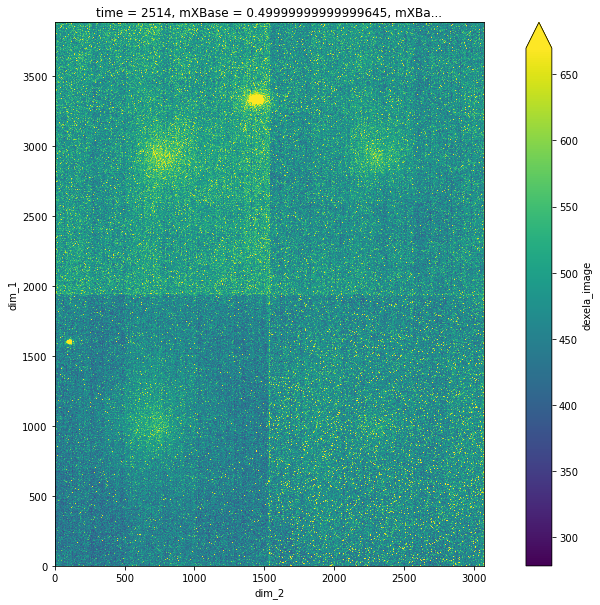

In [10]:
_ = my_color_map(test_dexela_image, size=10)

We subtract the background. The result looks fine.

In [11]:
test_result = average_subtract_fill_zero(test_dexela_image, background_dexela_image)
test_result

<xarray.DataArray 'dexela_image' (dim_1: 3888, dim_2: 3072)>
array([[ 0.,  3.,  0., ..., 17.,  0.,  2.],
       [ 6.,  0.,  0., ...,  0., 17., 18.],
       [ 4.,  4., 15., ...,  0.,  3.,  3.],
       ...,
       [16.,  0., 10., ...,  4., 13.,  0.],
       [ 0.,  7., 13., ...,  4.,  1.,  5.],
       [26., 26.,  0., ...,  9.,  5.,  0.]])
Coordinates:
    time                  int64 2514
    mXBase                float64 0.5
    mXBase_user_setpoint  float64 0.5
    mYBase                float64 50.0
    mYBase_user_setpoint  float64 50.0
Dimensions without coordinates: dim_1, dim_2

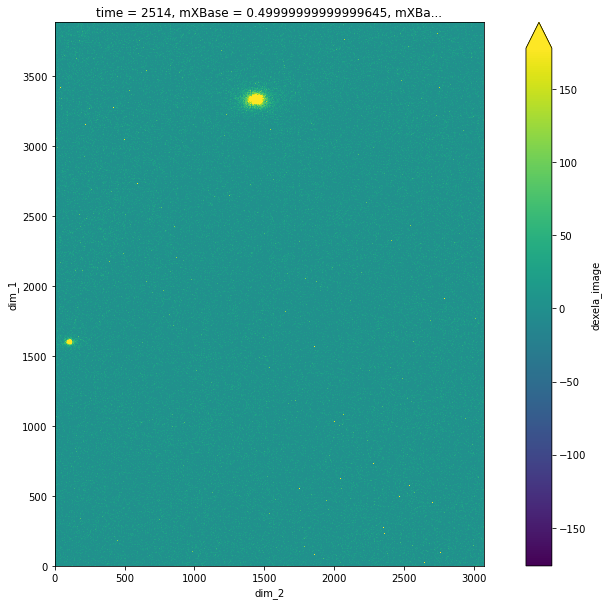

In [12]:
_ = my_color_map(test_result, size=10)

### Try the peak tracking

The algorithm finds two peaks on the image. It is reasonable.

In [129]:
df = my_locate(test_result, minmass=15000)
df

,y,x,mass,size,ecc,signal,raw_mass,ep,time,mXBase,mXBase_user_setpoint,mYBase,mYBase_user_setpoint
0,1601.248804,104.571604,651729.646792,4.653076,0.050932,6794.123704,2095808.0,0.000237,2514,0.5,0.5,50.0,50.0
1,3343.661755,1435.405521,329102.023514,4.315059,0.352727,4902.426516,1925632.0,0.000258,2514,0.5,0.5,50.0,50.0


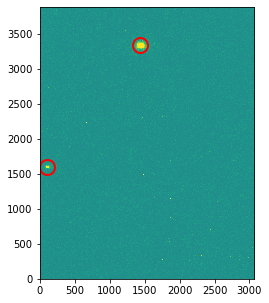

In [130]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
my_annotate_image(df, test_result, ax)

### Test if we use a background image

In [127]:
another_image = data["dexela_image"][4523]
processed_image = average_subtract_fill_zero(another_image, background_dexela_image)
df = my_locate(processed_image, minmass=15000)

/home/stao/miniconda3/envs/khalifah/lib/python3.9/site-packages/trackpy/feature.py:429: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "


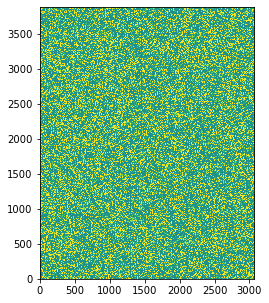

In [128]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
my_annotate_image(df, processed_image, ax)